In [23]:
%matplotlib_svg
import pylab as pl
import numpy as np
import pandas as pd
from glob import glob
pl.rcParams['axes.grid'] = True
pd.set_option("display.show_dimensions", False)
pd.set_option("display.float_format", "{:5.3g}".format)

## 数据处理和可视化实例

### 分析Pandas项目的提交历史

In [24]:
def read_git_log(log_fn):
    import io
    with io.open(log_fn, "r", encoding="utf8") as f:
        
        author = datetime = None
        message = []
        message_start = False
        for line in f:
            line = line.strip()
            if not line:
                continue
            
            if line.startswith("commit"):
                if author is not None:
                    yield author, datetime, "\n".join(message)
                    del message[:]
                message_start = False
            elif line.startswith("Author:"):
                author = line[line.index(":")+1 : line.index("<")].strip()
            elif line.startswith("Date:"):
                datetime = line[line.index(":")+1 :].strip()
                message_start = True
            elif message_start:
                message.append(line)

In [25]:
df_commit = pd.DataFrame(read_git_log("data/pandas.log"), 
                         columns=["Author", "DateString", "Message"])
print((df_commit.shape))

(12109, 3)


In [26]:
df_commit["Date"] = pd.to_datetime(df_commit.DateString)
print((df_commit[["DateString", "Date"]].head()))

                       DateString                Date
0   Tue Jul 7 23:43:31 2015 -0500 2015-07-08 04:43:31
1   Tue Jul 7 12:18:50 2015 -0700 2015-07-07 19:18:50
2   Tue Jul 7 13:37:38 2015 -0500 2015-07-07 18:37:38
3  Sat Jun 27 15:11:12 2015 -0700 2015-06-27 22:11:12
4   Tue Jul 7 10:53:55 2015 -0500 2015-07-07 15:53:55


In [27]:
df_commit["Timezone"] = df_commit.DateString.str[-5:]

In [28]:
import re
df_commit["Type"] = df_commit.Message.str.extract(r"^([A-Z/]{2,12})", flags=re.MULTILINE)

In [29]:
tz_counts = pd.value_counts(df_commit.Timezone)
type_counts = pd.value_counts(df_commit.Type)

%C tz_counts.head(); type_counts.head()

tz_counts.head()  type_counts.head()
----------------  ------------------
-0400    5057     BUG    3005       
-0500    2793     ENH    1720       
-0700    1141     DOC    1666       
+0200    1052     TST    1117       
-0800     519     CLN     424       
dtype: int64      dtype: int64      


In [30]:
df_commit.set_index("Date", drop=False, inplace=True)
df_commit.sort_index(inplace=True)

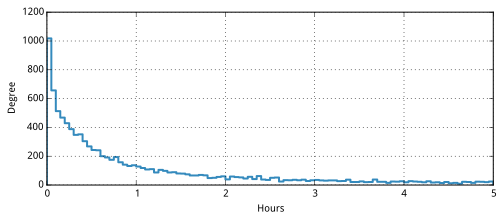

In [31]:
#%fig=两次提交的时间间隔统计
time_delta = df_commit.Date.diff(1).dropna() #❶
hours_delta = time_delta.dt.days * 24 + time_delta.dt.seconds / 3600.0 #❷
ax = hours_delta.plot(kind="hist", figsize=(8, 3),   #❸
                      bins=100, histtype="step", range=(0, 5), linewidth=2)
ax.set_xlabel("Hours");

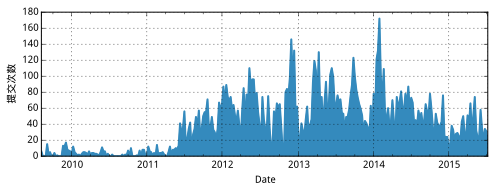

In [32]:
#%fig=每个星期的提交次数
ax = df_commit.Author.resample("W", how="count").plot(kind="area", figsize=(8, 2.5))
ax.grid(True)
ax.set_ylabel("提交次数");

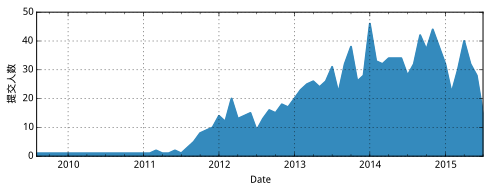

In [33]:
#%fig=每个月的提交人数
ax = df_commit.Author.resample("M", how=lambda s:len(s.unique())).plot(
    kind="area", figsize=(8, 2.5))
ax.set_ylabel("提交人数");

> **QUESTION**

> 请读者思考如何使用`groupby()`实现与上述`resample()`相同的运算。

In [34]:
s_authors = df_commit.Author.value_counts()
print((s_authors.head()))

Wes McKinney     3115
jreback          3009
y-p               943
Chang She         629
Phillip Cloud     596
dtype: int64


In [35]:
df_counts = pd.crosstab(df_commit.index.to_period("M"), df_commit.Author)
df_counts.index.name = "Month"
print((df_counts.shape))

(72, 485)


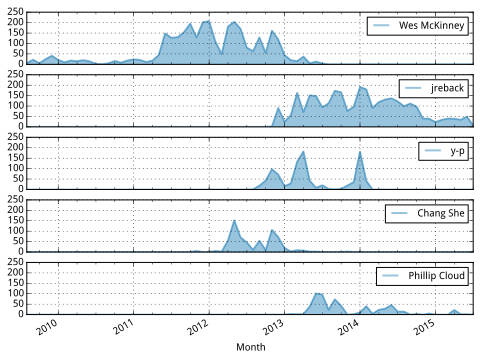

In [36]:
#%fig=前五名作者的每个月提交次数
df_counts[s_authors.head(5).index].plot(kind="area", 
                                      subplots=True, 
                                      figsize=(8, 6), 
                                      color=pl.rcParams['axes.color_cycle'][0],
                                      alpha=0.5,
                                      sharex=True,
                                      sharey=True);

In [37]:
daily_commit = df_commit.index.to_period("D").value_counts() #❶
daily_commit.index = pd.MultiIndex.from_arrays([daily_commit.index.asfreq("W"),  #❷
                                                daily_commit.index.weekday])
daily_commit = daily_commit.sort_index()
active_data = daily_commit.unstack(0).iloc[:, -60:].fillna(0) #❸

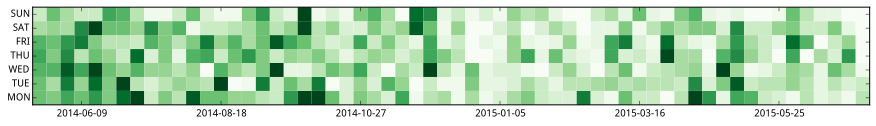

In [38]:
#%fig=Pandas项目的活动记录图
fig, ax = pl.subplots(figsize=(15, 4))
ax.set_aspect("equal")
ax.pcolormesh(active_data.values, cmap="Greens", 
              vmin=0, vmax=active_data.values.max() * 0.75) #❹

tick_locs = np.arange(3, 60, 10)
ax.set_xticks(tick_locs + 0.5)
ax.set_xticklabels(active_data.columns[tick_locs].to_timestamp(how="start").format())
ax.set_yticks(np.arange(7) + 0.5)

from pandas.tseries.frequencies import DAYS
ax.set_yticklabels(DAYS);

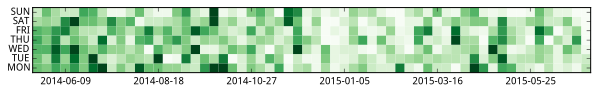

In [39]:
#%nofig
from scpy2.pandas import plot_dataframe_as_colormesh

plot_dataframe_as_colormesh(active_data, xtick_start=3, xtick_step=10, 
               xtick_format=lambda period:str(period.start_time.date()),
               ytick_format=dict(list(zip(list(range(7)), DAYS))).get,
               cmap="Greens", vmin=0, vmax=active_data.values.max() * 0.75);

### 分析空气质量数据

In [44]:
store = pd.HDFStore("data/aqi/aqi.hdf5")
df_aqi = store.select("aqi")
df_aqi.head()

,Time,City,Position,AQI,Level,PM2_5,PM10,CO,NO2,O3,SO2
1,2014-04-11 15:00:00,上海,普陀,76,良,49,101,0,0,0,0
2,2014-04-11 15:00:00,上海,十五厂,72,良,52,94,0.479,53,124,9
3,2014-04-11 15:00:00,上海,虹口,80,良,59,98,0.612,52,115,11
4,2014-04-11 15:00:00,上海,徐汇上师大,74,良,54,87,0.706,43,113,14
5,2014-04-11 15:00:00,上海,杨浦四漂,84,良,62,99,0.456,43,82,9


In [45]:
print((df_aqi.City.value_counts()))

天津     134471
北京     109999
上海      92745
天津市        13
北京市        12
上海市        10
dtype: int64


In [46]:
df_aqi["City"] = df_aqi.City.str.replace("市", "").astype("category")
print((df_aqi.City.value_counts()))

天津    134484
北京    110011
上海     92755
dtype: int64


In [47]:
corr = df_aqi.corr()
print(corr)

         AQI  PM2_5   PM10     CO    NO2     O3    SO2
AQI        1  0.944  0.694  0.611  0.534 -0.136   0.42
PM2_5  0.944      1  0.569  0.633  0.556 -0.169  0.426
PM10   0.694  0.569      1   0.46  0.472 -0.136  0.414
CO     0.611  0.633   0.46      1  0.565 -0.233  0.538
NO2    0.534  0.556  0.472  0.565      1 -0.439  0.448
O3    -0.136 -0.169 -0.136 -0.233 -0.439      1 -0.198
SO2     0.42  0.426  0.414  0.538  0.448 -0.198      1


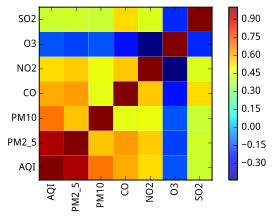

In [48]:
#%fig=空气质量参数之间的相关性
fig, ax = pl.subplots()
plot_dataframe_as_colormesh(corr, ax=ax, colorbar=True, xtick_rot=90);

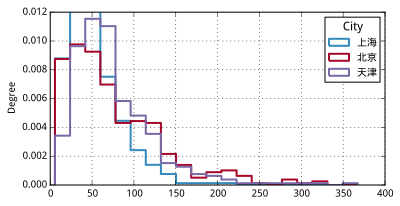

In [49]:
#%fig[1x2]=每个城市的日平均PM2.5的分布图
daily_city_groupby = df_aqi.groupby([df_aqi.Time.dt.date, "City"]) #❶
mean_pm2_5 = daily_city_groupby.PM2_5.mean().unstack()  #❷
mean_pm2_5.plot(kind="hist", histtype="step", bins=20, normed=True, lw=2) #❸;

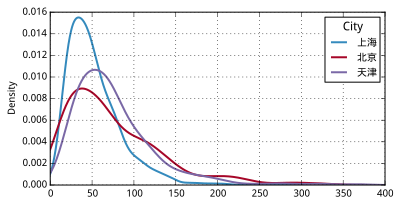

In [51]:
ax = mean_pm2_5.plot(kind="kde")
ax.set_xlim(0, 400);

In [59]:
mean_pm2_5.corr()
#%hide
corr = mean_pm2_5.corr()
corr.index.name = None
corr.columns.name = None
corr

,上海,北京,天津
上海,1,-0.146,0.0718
北京,-0.146,1,0.691
天津,0.0718,0.691,1


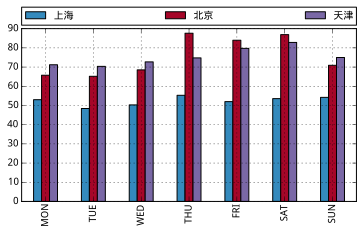

In [53]:
#%fig=一星期中PM2.5的平均值
week_mean = df_aqi.groupby([df_aqi.Time.dt.dayofweek, "City"]).PM2_5.mean()
ax = week_mean.unstack().plot(kind="Bar")
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0.)
from pandas.tseries.frequencies import DAYS
ax.set_xticklabels(DAYS);

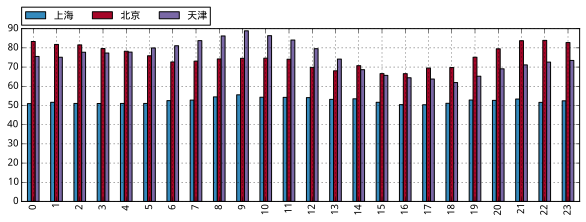

In [54]:
#%fig=一天中不同时段的PM2.5的平均值
hour_mean = df_aqi.groupby([df_aqi.Time.dt.hour, "City"]).PM2_5.mean()
ax = hour_mean.unstack().plot(kind="Bar", figsize=(10, 3))
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, borderaxespad=0.);

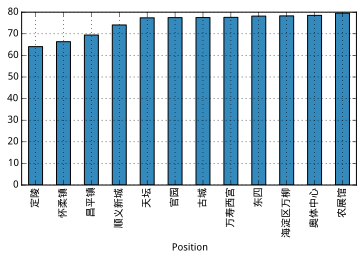

In [55]:
#%fig=北京市各个观测点的PM2.5的平均值
df_bj = df_aqi.query("City=='北京'")
month_place_mean = df_bj.groupby([df_bj.Time.dt.to_period("M"), "Position"]).PM2_5.mean()
place_mean = month_place_mean.mean(level=1).order()
place_mean.plot(kind="bar");

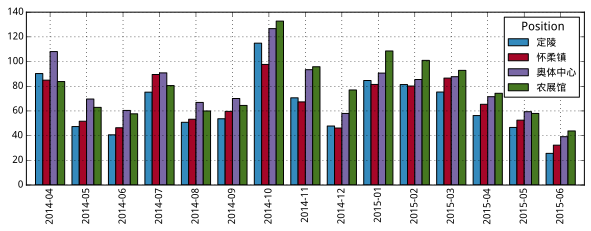

In [56]:
#%fig=北京市各观测点的月平均PM2.5值
places = place_mean.iloc[[0, 1, -2, -1]].index
month_place_mean.unstack().loc[:, places].plot(kind="bar", figsize=(10, 3), width=0.8);